# Results for XGB when applying syn tranformation to both premise and hypothesis

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML 
from lr.analysis.util import get_ts_from_results_folder, get_rho_stats_from_result_list
from tqdm import tqdm

## Get Results

In [2]:
all_accs = []
all_transformed_accs = []
all_paired_t_p_values = []
all_cochran_p_values = []
test_repetitions = 20


batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    test_accuracy  = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch{}/".format(i),
                                                 stat="test_accuracy")
    
    transformed_test_accuracy = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch{}/".format(i),
                                                           stat="transformed_test_accuracy")
    
    paired_t_p_value  = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch{}/".format(i),
                                                    stat="paired_t_p_value")
    
    cochran_p_value = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch{}/".format(i),
                                                  stat="cochran_p_value")
    
    
    all_accs.append(test_accuracy)
    all_transformed_accs.append(transformed_test_accuracy)
    all_paired_t_p_values.append(paired_t_p_value)
    all_cochran_p_values.append(cochran_p_value)

100%|██████████| 20/20 [00:43<00:00,  2.17s/it]


## Accuracy

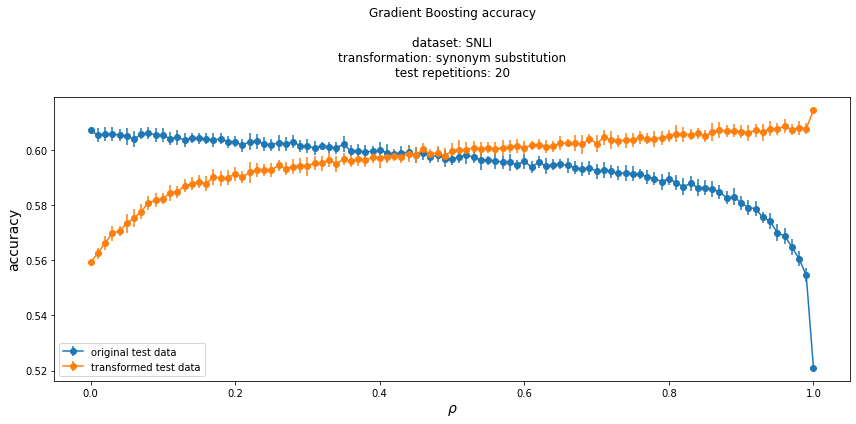

In [3]:
x, y, error = get_rho_stats_from_result_list(all_accs)

x_t, y_t, error_t = get_rho_stats_from_result_list(all_transformed_accs)

fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(x, y, yerr=error, fmt='-o', label="original test data");
ax.errorbar(x_t, y_t, yerr=error_t, fmt='-o', label="transformed test data");
ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("accuracy", fontsize=14);
ax.set_title("Gradient Boosting accuracy\n\ndataset: SNLI\ntransformation: synonym substitution\ntest repetitions: {}\n".format(test_repetitions));
fig.tight_layout()
fig.savefig('figs/gb_acc_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

## Accuracy difference

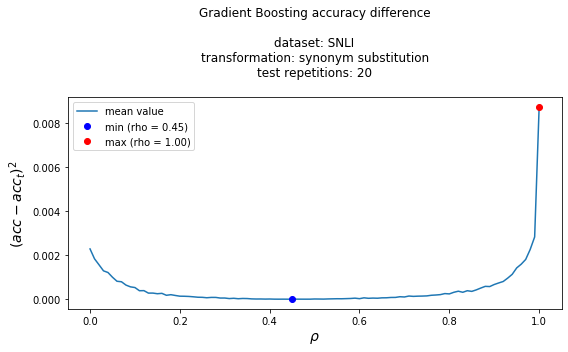

In [4]:
df_acc = pd.DataFrame({"rho":x,
                       "acc":y,
                       "acc_t":y_t}).set_index("rho")

diff = (df_acc.acc - df_acc.acc_t) ** 2
diff.name = "mean value"

id_min = diff.argmin() 
id_max = diff.argmax()
rho_min, v_min = diff.index[id_min], diff.iloc[id_min], 
rho_max, v_max = diff.index[id_max], diff.iloc[id_max]


fig, ax = plt.subplots(figsize=(8,5))
diff.plot();
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel(r"$(acc - acc_t)^{2}$", fontsize=14);
ax.set_title("Gradient Boosting accuracy difference\n\ndataset: SNLI\ntransformation: synonym substitution\ntest repetitions: {}\n".format(test_repetitions));
ax.plot(rho_min, v_min, "o", color="blue", label="min (rho = {:.2f})".format(rho_min))
ax.plot(rho_max, v_max, "o", color="red", label="max (rho = {:.2f})".format(rho_max))
fig.tight_layout()
ax.legend(loc="best");
fig.savefig('figs/gb_diff_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

## P-values

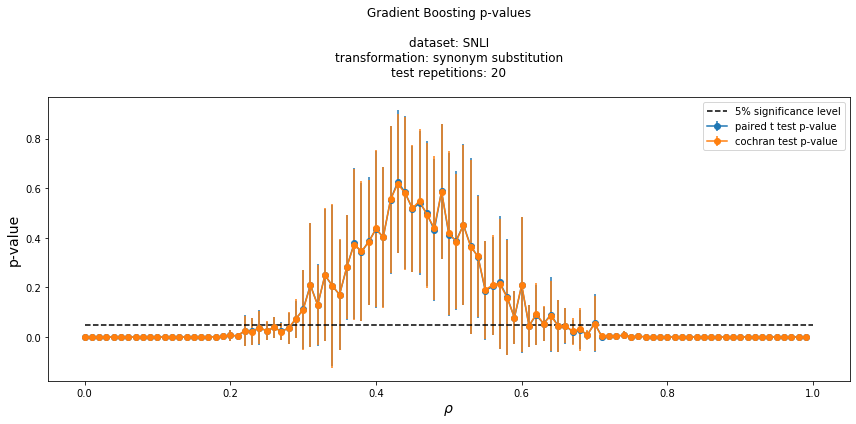

In [5]:
x, y, error = get_rho_stats_from_result_list(all_paired_t_p_values)

x_t, y_t, error_t = get_rho_stats_from_result_list(all_cochran_p_values)

cut = 100

fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(x[:cut], y[:cut], yerr=error[:cut], fmt='-o', label="paired t test p-value");
ax.errorbar(x_t[:cut], y_t[:cut], yerr=error_t[:cut], fmt='-o', label="cochran test p-value");
ax.hlines(0.05,x[0], x[cut], color="k", linestyles = 'dashed', label="5% significance level");
ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("p-value", fontsize=14);
ax.set_title("Gradient Boosting p-values\n\ndataset: SNLI\ntransformation: synonym substitution\ntest repetitions: {}\n".format(test_repetitions));
fig.tight_layout()
fig.tight_layout()
fig.savefig('figs/gb_p_values_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

## P-values: taking a closer look

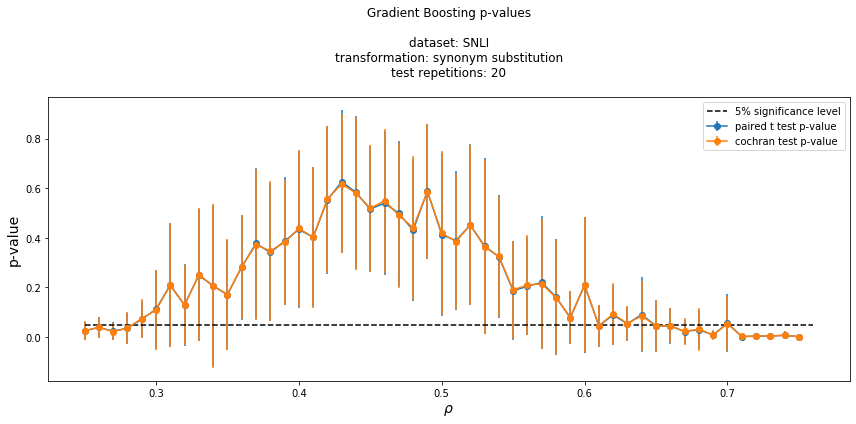

In [6]:
cut1 = 25
cut2 = 76

fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(x[cut1:cut2], y[cut1:cut2], yerr=error[cut1:cut2], fmt='-o', label="paired t test p-value");
ax.errorbar(x_t[cut1:cut2], y_t[cut1:cut2], yerr=error_t[cut1:cut2], fmt='-o', label="cochran test p-value");
ax.hlines(0.05,x[cut1], x[cut2], color="k", linestyles = 'dashed', label="5% significance level");
ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("p-value", fontsize=14);
ax.set_title("Gradient Boosting p-values\n\ndataset: SNLI\ntransformation: synonym substitution\ntest repetitions: {}\n".format(test_repetitions));
fig.tight_layout()
fig.savefig('figs/gb_p_values_snli_syn_p_h_zoom.png', bbox_inches=None, pad_inches=0.5)

### Ploting the std of P-values

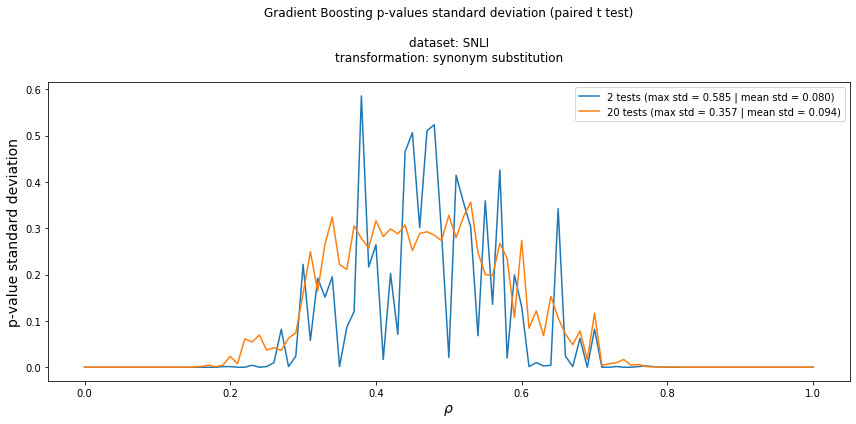

In [7]:
all_errors = []

for i in [2, 20]:
    x, _, error = get_rho_stats_from_result_list(all_paired_t_p_values[:i])
    error = pd.Series(error, index=x)
    error.name = "{} tests (max std = {:.3f} | mean std = {:.3f})".format(i, error.max(), error.mean())
    all_errors.append(error)

fig, ax = plt.subplots(figsize=(12,6))
pd.DataFrame(all_errors).transpose().plot(ax=ax);
ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("p-value standard deviation", fontsize=14);
ax.set_title("Gradient Boosting p-values standard deviation (paired t test)\n\ndataset: SNLI\ntransformation: synonym substitution\n");
fig.tight_layout()
fig.savefig('figs/gb_p_values_std_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

### Ploting the histogram of P-values

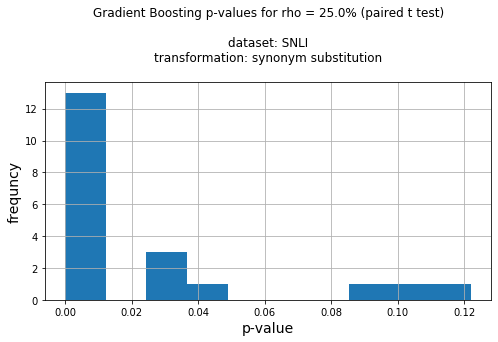

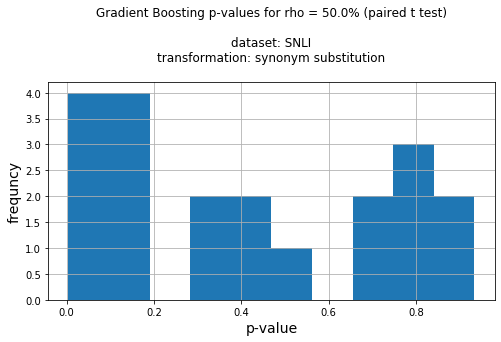

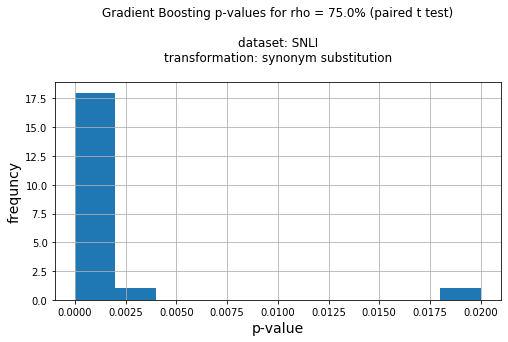

In [8]:
for rho in [0.25, 0.50, 0.75]:
    fig, ax = plt.subplots(figsize=(8,4))
    pd.DataFrame(all_paired_t_p_values).transpose().loc[rho,:].hist(ax=ax);
    ax.set_xlabel("p-value", fontsize=14);
    ax.set_ylabel("frequncy", fontsize=14);
    ax.set_title("Gradient Boosting p-values for rho = {:.1%} (paired t test)\n\ndataset: SNLI\ntransformation: synonym substitution\n".format(rho));
    plt.show()

### Mean P-value over $\rho$

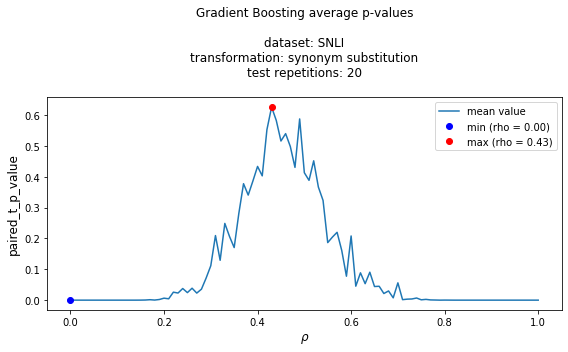

In [10]:
x, y, error = get_rho_stats_from_result_list(all_paired_t_p_values)

p_values = pd.Series(y, index=x)
p_values.name = "mean value"
p_values.index.name = "rho"

id_min = p_values.argmin() 
id_max = p_values.argmax()
rho_min, v_min = p_values.index[id_min], p_values.iloc[id_min], 
rho_max, v_max = p_values.index[id_max], p_values.iloc[id_max]


fig, ax = plt.subplots(figsize=(8,5))
p_values.plot();
ax.set_xlabel(r"$\rho$", fontsize=12);
ax.set_ylabel("paired_t_p_value", fontsize=12);
ax.set_title("Gradient Boosting average p-values\n\ndataset: SNLI\ntransformation: synonym substitution\ntest repetitions: {}\n".format(test_repetitions));
ax.plot(rho_min, v_min, "o", color="blue", label="min (rho = {:.2f})".format(rho_min))
ax.plot(rho_max, v_max, "o", color="red", label="max (rho = {:.2f})".format(rho_max))
fig.tight_layout()
ax.legend(loc="best");
fig.savefig('figs/gb_average_p_value_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)